### IMPORTS AND SETUP

In [1]:
import sys
print("Python executable:", sys.executable)

Python executable: /home/megakruk/.pyenv/versions/3.10.10/bin/python3.10


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
import geopandas as gpd
import shapely.wkt
import os, warnings
import logging
import shap

logging.basicConfig(filename='warnings.log', level=logging.DEBUG)

def custom_warning_handler(message, category, filename, lineno, file=None, line=None):
    logging.debug(f'{category.__name__}: {message} in {filename}:{lineno}')

warnings.showwarning = custom_warning_handler

from shapely.geometry import Point
import rioxarray as rxr
import rasterio

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.base import clone
from joblib import dump

import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SHOW_PLOTS = True  # if you want to display some bar charts, etc.

/home/megakruk/.pyenv/versions/3.10.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### FEATURE TOGGLES

In [3]:
FEATURE_FLAGS = {
    # building coverage
    "building_cov_50m":  True,
    "building_cov_100m": False,
    "building_cov_200m": False,
    "building_cov_500m": False,

    # distance to water and parks
    "distance_water":     False,
    "distance_parks":     False,

    # street tree coverage
    "street_tree_cov_500m": False,

    # distance to subway
    "dist_to_closest_subway_station": False,

    # raster-based features
    "lst_value":  False,
    "ndvi_value": False,
    "ndbi_value": False,
    "ndwi_value": False,
    "evi_value":  False,  # if you later want to compute EVI from raw bands

    # data fram MapPLUTO
    # "NumBldgs": True, "NumFloors": True, "UnitsRes": True, "UnitsTotal": True,
    # "LotArea": True, "BldgArea": True, "ComArea": True, "ResArea": True,
    # "AssessLand": True, "AssessTot": True, "ExemptTot": True,
    # "BuiltFAR": True, "ResidFAR": True, "CommFAR": True, "FacilFAR": True,
    # "YearBuilt": True, "YearAlter1": True, "YearAlter2": True, "Overlay1": True, 
    # "SPDist1": True, "LandUse": True, "BldgClass": True, "ZoneDist1": True,
    "map_pluto_data": True,

    # disabled features (avoid potential compliance issues)
    "dist_to_closest_calculated_city_centroid": False,
    "location_cluster": False,
    "official_cluster": False,
    "population_density": False,
}

### HELPER FUNCTIONS

In [4]:
def coverage_fraction(geom, polygon_gdf, radius=50):
    """
    coverage_fraction:
      - We do buffer around 'geom' by 'radius'.
      - Clip polygon_gdf with that buffer.
      - Sum area of clipped polygons / area of buffer => coverage fraction.
    """
    buffer_poly = geom.buffer(radius)
    clipped = gpd.clip(polygon_gdf, buffer_poly)
    area_polygons = clipped.geometry.area.sum()
    area_buffer = buffer_poly.area
    return area_polygons / area_buffer if area_buffer > 0 else 0


def building_coverage_fraction(geom, building_gdf, radius=50):
    """Simple wrapper specifically for building footprints coverage."""
    return coverage_fraction(geom, building_gdf, radius)


def distance_to_polygons(geom, poly_gdf):
    dists = poly_gdf.geometry.distance(geom)
    return dists.min() if len(dists) > 0 else np.nan


def extract_raster_value(geom, raster, band_index=1, method="nearest"):
    """Return the pixel value from raster at geom's location."""
    x, y = geom.x, geom.y
    val = raster.sel(x=x, y=y, band=band_index, method=method).values
    return float(val)


def compute_evi(blue, red, nir, L=1.0, C1=6.0, C2=7.5, G=2.5):
    """
    If you want to compute EVI from raw bands.
    Currently not used if 'evi_value' == False.
    """
    return G * (nir - red) / (nir + C1*red - C2*blue + L)

def get_zoning_code(geom, gdf_zoning):
    """
    Return the zoning code from gdf_zoning polygon that contains 'geom'.
    If multiple polygons or none found, handle accordingly.
    """
    # Create a one-row GeoDataFrame for the point
    pt = gpd.GeoDataFrame([1], geometry=[geom], crs=gdf_zoning.crs)
    join_res = gpd.sjoin(pt, gdf_zoning, how="left", predicate="within")
    if len(join_res) == 0:
        return "NONE"
    else:
        # Return the zoning code column, e.g., 'ZONEDIST'
        return join_res.iloc[0]["ZONEDIST"]

# def get_pluto_features(geom, gdf_pluto, pluto_columns, initial_buffer=1.0, max_buffer=16.0):
#     """
#     For a given point geometry, first try to find a PLUTO polygon that contains it.
#     If none is found, gradually increase the buffer until max_buffer is reached.
#     Returns a dictionary of values for the specified pluto_columns.
#     """
#     buffer_distance = initial_buffer
#     candidate_idx = list(gdf_pluto.sindex.query(geom, predicate="within"))
    
#     # Gradually increase the buffer if no candidate is found
#     while not candidate_idx and buffer_distance <= max_buffer:
#         candidate_idx = list(gdf_pluto.sindex.query(geom.buffer(buffer_distance), predicate="intersects"))
#         buffer_distance *= 2  # Double the buffer and try again
    
#     if not candidate_idx:
#         return {col: np.nan for col in pluto_columns}
    
#     # If multiple candidates, select the one with the largest intersection area.
#     # For a point (or near-point) this may not be very informative, so we choose the first.
#     best_match = gdf_pluto.iloc[candidate_idx[0]]
#     return best_match[pluto_columns].to_dict()

def get_pluto_features(geom, gdf, pluto_columns, initial_buffer=1.0, max_buffer=512.0):
    """
    For a given point geometry, first try to find a polygon in 'gdf' (e.g. your enriched gdf_buildings)
    that contains the point. If none is found, gradually increase the buffer (doubling each time)
    until a candidate is found or until max_buffer is reached.
    
    Parameters:
      - geom: a shapely geometry (typically a Point).
      - gdf: a GeoDataFrame with the PLUTO (or enriched) features.
      - pluto_columns: list of column names to extract.
      - initial_buffer: starting buffer distance in the CRS units (e.g., meters).
      - max_buffer: maximum buffer distance to try.
    
    Returns:
      A dictionary mapping each column in pluto_columns to its value in the found polygon;
      if no polygon is found, returns a dictionary with np.nan for each column.
    """
    # First try an exact "within" query (no buffer)
    candidate_idx = list(gdf.sindex.query(geom, predicate="within"))
    
    buffer_distance = initial_buffer
    # If no candidate is found, gradually increase the search area.
    while not candidate_idx and buffer_distance <= max_buffer:
        # Use a buffer around the point and look for intersections.
        candidate_idx = list(gdf.sindex.query(geom.buffer(buffer_distance), predicate="intersects"))
        buffer_distance *= 2  # Double the buffer and try again.
    
    if not candidate_idx:
        # print("No candidate!")
        # If still nothing is found, return NaNs for all the requested columns.
        return {col: np.nan for col in pluto_columns}
    
    # If multiple candidates are found, select the first candidate.
    best_match = gdf.iloc[candidate_idx[0]]
    return best_match[pluto_columns].to_dict()

In [5]:
# Define the list of PLUTO columns you wish to extract.
pluto_columns = [
    "NumBldgs", "NumFloors", "UnitsRes", "UnitsTotal",
    "LotArea", "BldgArea", "ComArea", "ResArea",
    "AssessLand", "AssessTot", "ExemptTot",
    "BuiltFAR", "ResidFAR", "CommFAR", "FacilFAR",
    "YearBuilt", "YearAlter1", "YearAlter2",
    "Overlay1", "SPDist1", "LandUse", "BldgClass", "ZoneDist1"
]

### LOAD GEOSPATIAL DATA

In [7]:
print("Loading building footprints, water, parks, street trees, subway stations...")

# 4.1 Building footprints
gdf_buildings = gpd.read_file("./data/Building_Footprint.kml").to_crs("EPSG:2263")

# 4.2 Water polygons
df_water = pd.read_csv("./data/NYC_Planimetric_Database__Hydrography_20250123.csv")
df_water["geometry"] = df_water["the_geom"].apply(shapely.wkt.loads)
gdf_water = gpd.GeoDataFrame(df_water, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")

# 4.3 Parks polygons
gdf_parks = gpd.read_file("./data/Parks_Properties_20250123.kml").to_crs("EPSG:2263")

# 4.4 Street Trees
df_trees = pd.read_csv("./data/2015_Street_Tree_Census_-_Tree_Data_20250205.csv")
df_trees.rename(columns={"latitude": "lat", "longitude": "lon"}, inplace=True)
gdf_trees_pts = gpd.GeoDataFrame(
    df_trees,
    geometry=[Point(lon, lat) for lon, lat in zip(df_trees["lon"], df_trees["lat"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
# approximate canopy with 2m buffer
gdf_trees_poly = gdf_trees_pts.copy()
gdf_trees_poly["geometry"] = gdf_trees_poly.geometry.buffer(2.0)

# 4.5 Subway stations
gdf_stations = gpd.read_file("./data/MTA Subway Stations_20250206.geojson").to_crs("EPSG:2263")

# 4.6 MapPLUTO
gdf_pluto = gpd.read_file("./data/MapPLUTO.shp")

print("Done loading geospatial data.")

Loading building footprints, water, parks, street trees, subway stations...
Done loading geospatial data.


In [8]:
gdf_buildings["original_index"] = gdf_buildings.index  # before the join

# Then do the spatial join
joined = gpd.sjoin(gdf_buildings, gdf_pluto, how="left", predicate="intersects")

# Count how many times each building index appears
dupes = joined.groupby("original_index").size()
dupes[dupes > 1].sort_values(ascending=False).head(10)

original_index
7465    81
6686    76
7461    69
9158    68
8602    65
7750    64
8434    64
8460    64
8410    63
8320    63
dtype: int64

In [9]:
gdf_buildings = joined.drop_duplicates(subset=["original_index"])
gdf_buildings.columns

Index(['Name', 'Description', 'geometry', 'original_index', 'index_right', 'Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010', 'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL', 'CondoNo', 'Tract2010', 'XCoord',
       

In [10]:
gdf_buildings["ZoneDist1"] = gdf_buildings["ZoneDist1"].fillna("UNKNOWN")
gdf_buildings["Overlay1"] = gdf_buildings["Overlay1"].fillna("UNKNOWN")
gdf_buildings["SPDist1"] = gdf_buildings["SPDist1"].fillna("UNKNOWN")
gdf_buildings["BldgClass"] = gdf_buildings["BldgClass"].fillna("UNKNOWN")
gdf_buildings["Borough"] = gdf_buildings["Borough"].fillna("UNKNOWN")
gdf_buildings["LandUse"] = gdf_buildings["LandUse"].fillna("UNKNOWN")
median_val_num_floors = gdf_buildings["NumFloors"].median()
gdf_buildings["NumFloors"] = gdf_buildings["NumFloors"].fillna(median_val_num_floors)
median_val_num_bldgs = gdf_buildings["NumBldgs"].median()
gdf_buildings["NumBldgs"] = gdf_buildings["NumBldgs"].fillna(median_val_num_bldgs)
median_val_num_units_res = gdf_buildings["UnitsRes"].median()
gdf_buildings["UnitsRes"] = gdf_buildings["UnitsRes"].fillna(median_val_num_units_res)
median_val_num_units_total = gdf_buildings["UnitsTotal"].median()
gdf_buildings["UnitsTotal"] = gdf_buildings["UnitsTotal"].fillna(median_val_num_units_total)
median_val_lot_area = gdf_buildings["LotArea"].median()
gdf_buildings["LotArea"] = gdf_buildings["LotArea"].fillna(median_val_lot_area)
median_val_bldg_area = gdf_buildings["BldgArea"].median()
gdf_buildings["BldgArea"] = gdf_buildings["BldgArea"].fillna(median_val_bldg_area)
median_val_com_area = gdf_buildings["ComArea"].median()
gdf_buildings["ComArea"] = gdf_buildings["ComArea"].fillna(median_val_com_area)
median_val_res_area = gdf_buildings["ResArea"].median()
gdf_buildings["ResArea"] = gdf_buildings["ResArea"].fillna(median_val_res_area)
median_val_assess_land = gdf_buildings["AssessLand"].median()
gdf_buildings["AssessLand"] = gdf_buildings["AssessLand"].fillna(median_val_assess_land)
median_val_assess_tot = gdf_buildings["AssessTot"].median()
gdf_buildings["AssessTot"] = gdf_buildings["AssessTot"].fillna(median_val_assess_tot)
median_val_exempt_tot = gdf_buildings["ExemptTot"].median()
gdf_buildings["ExemptTot"] = gdf_buildings["ExemptTot"].fillna(median_val_exempt_tot)
median_val_built_far = gdf_buildings["BuiltFAR"].median()
gdf_buildings["BuiltFAR"] = gdf_buildings["BuiltFAR"].fillna(median_val_built_far)
median_val_resid_far = gdf_buildings["ResidFAR"].median()
gdf_buildings["ResidFAR"] = gdf_buildings["ResidFAR"].fillna(median_val_resid_far)
median_val_comm_far = gdf_buildings["CommFAR"].median()
gdf_buildings["CommFAR"] = gdf_buildings["CommFAR"].fillna(median_val_comm_far)
median_val_facil_far = gdf_buildings["FacilFAR"].median()
gdf_buildings["FacilFAR"] = gdf_buildings["FacilFAR"].fillna(median_val_facil_far)
median_val_year_built = gdf_buildings["YearBuilt"].median()
gdf_buildings["YearBuilt"] = gdf_buildings["YearBuilt"].fillna(median_val_year_built)
median_val_year_alter_1 = gdf_buildings["YearAlter1"].median()
gdf_buildings["YearAlter1"] = gdf_buildings["YearAlter1"].fillna(median_val_year_alter_1)
median_val_year_alter_2 = gdf_buildings["YearAlter2"].median()
gdf_buildings["YearAlter2"] = gdf_buildings["YearAlter1"].fillna(median_val_year_alter_1)

In [11]:
columns_with_nan = gdf_buildings.columns[gdf_buildings.isna().any()].tolist()
print("Columns with at least one NaN:", columns_with_nan)

Columns with at least one NaN: ['index_right', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010', 'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay2', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'Easements', 'OwnerType', 'OwnerName', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'HistDist', 'Landmark', 'BoroCode', 'BBL', 'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode', 'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID', 'FIRM07_FLA', 'PFIRM15_FL', 'Version', 'DCPEdited', 'Latitude', 'Longitude', 'Notes', 'Shape_Leng', 'Shape_Area']


In [12]:
gdf_buildings.columns

Index(['Name', 'Description', 'geometry', 'original_index', 'index_right', 'Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010', 'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL', 'CondoNo', 'Tract2010', 'XCoord',
       

In [13]:
# gdf_buildings = gdf_buildings.dropna(axis=1)
gdf_buildings.count()

Name              9436
Description       9436
geometry          9436
original_index    9436
index_right       9394
                  ... 
Latitude          9394
Longitude         9394
Notes                0
Shape_Leng        9394
Shape_Area        9394
Length: 99, dtype: int64

In [14]:
gdf_buildings.describe(include='all')

,Name,Description,geometry,original_index,index_right,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,Sanitboro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area
count,9436,9436,9436,9436.000000,9394.000000,9436,9394.000000,9394.000000,9394.000000,9394,9394,9394,9394,9392,9394.000000,9394.000000,9389,9394.000000,9394.000000,9394.000000,9388,9388,9186,9386,9436,614,17,2,9436,24,9436,39,0,24,9394,9436,9436,9394.000000,2833,9390,9.436000e+03,9.436000e+03,9.436000e+03,9.436000e+03,9.394000e+03,9394.000000,9394.000000,9394.000000,9394.000000,9.394000e+03,9391,9436.000000,9436.000000,9436.000000,9436.000000,9394.000000,9394.000000,9394.000000,9394.000000,8330,9391,9391,9391,9391,9.436000e+03,9.436000e+03,9.436000e+03,9436.000000,9436.000000,9436.000000,818,297,9436.000000,9436.000000,9436.000000,9436.000000,9394.000000,9.394000e+03,9394.000000,9394,9.394000e+03,9394.000000,9394,535,9385,9385,422,9.394000e+03,1739,9394,779,829,9394,1458,9394.000000,9394.000000,0,9394.0,9.394000e+03
unique,1,1,9433,NaN,NaN,3,NaN,NaN,NaN,349,2843,284,157,11,NaN,NaN,77,NaN,NaN,NaN,3,13,21,7782,89,56,11,2,9,4,25,4,0,1,2,180,12,NaN,5,6608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,2,10,6,NaN,NaN,NaN,NaN,NaN,NaN,44,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284,NaN,NaN,15,1,916,89,75,NaN,861,2,1,1,1,1,NaN,NaN,0,NaN,NaN
top,,,MULTIPOLYGON (((1005676.9002934109 249791.5436...,NaN,NaN,BX,NaN,NaN,NaN,2005400,10122003002,93,2000,12,NaN,NaN,L054,NaN,NaN,NaN,2,09,1A,1000 5 AVENUE,R7-1,R8,C2-8,C1-8X,UNKNOWN,C1-4,UNKNOWN,TA,NaN,LH-1A,N,C0,02,NaN,X,NYC HOUSING AUTHORITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0,N,5,0,NaN,NaN,NaN,NaN,NaN,NaN,Individual Landmark,INDIVIDUAL LANDMARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0093,NaN,NaN,3d,Y,199 999,21103,E-442,NaN,08/25/1988,1,1,1,24v4,t,NaN,NaN,NaN,NaN,NaN
freq,9436,9436,2,NaN,NaN,5915,NaN,NaN,NaN,158,51,249,932,1669,NaN,NaN,469,NaN,NaN,NaN,5885,1368,2502,50,2069,82,3,1,7816,11,8398,31,NaN,24,8736,767,2087,NaN,1260,484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6918,3766,5803,5036,3347,NaN,NaN,NaN,NaN,NaN,NaN,264,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249,NaN,NaN,2236,535,121,459,57,NaN,38,9391,779,829,9394,1458,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,4717.500000,48110.230999,NaN,2479.550777,341.000852,169.660102,NaN,NaN,NaN,NaN,NaN,12.434958,10298.170321,NaN,37.535874,20.198318,2926.719289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044709,NaN,NaN,4.231548e+05,1.345366e+05,5.551928e+04,7.752586e+04,1.238320e+04,3972.879923,3263.358207,1307.883223,1250.697892,3.357458e+04,NaN,3.559771,5.351408,99.479864,101.859262,181.957184,205.351688,73.154284,81.945087,NaN,NaN,NaN,NaN,NaN,1.798262e+07,2.959286e+07,2.623047e+07,1778.198389,657.450191,657.450191,NaN,NaN,2.714347,3.567008,0.613173,5.155394,1.629657,1.654453e+09,47.342133,NaN,1.006546e+06,238368.217479,NaN,NaN,NaN,NaN,NaN,3.104464e+08,NaN,NaN,NaN,NaN,NaN,NaN,40.820909,-73.919439,NaN,0.0,4.087140e+05
std,NaN,NaN,NaN,2724.082904,17968.046096,NaN,700.649338,1429.752502,47.448821,NaN,NaN,NaN,NaN,NaN,4.549113,336.766287,NaN,11.560405,5.088418,1613.812719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.288024,NaN,NaN,2.977558e+06,5.

46835


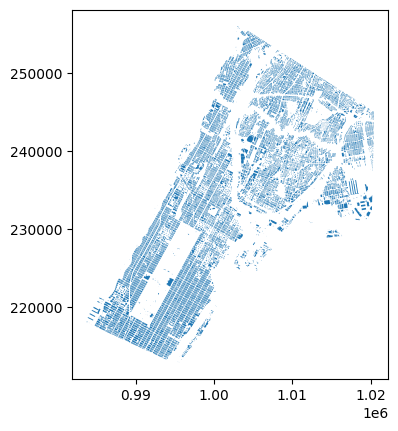

In [15]:
if SHOW_PLOTS:
    overlay_df = gpd.overlay(gdf_buildings, gdf_pluto, how="intersection")
    print(len(overlay_df))
    overlay_df.plot()

### LOAD + CHECK RASTERS

In [16]:
print("Loading reprojected LST + Indices...")

lst_raster = rxr.open_rasterio("Landsat_LST_v4_single_0601_0901.tiff")
lst_raster_2263 = lst_raster.rio.reproject("EPSG:2263")

indices_raster = rxr.open_rasterio("S2_indices_v4_single_0601_0901.tiff")
indices_raster_2263 = indices_raster.rio.reproject("EPSG:2263")

# Quick check for valid data
ratio_lst = (~lst_raster_2263.isnull()).mean().values
ratio_idx = (~indices_raster_2263.isnull()).mean().values

print(f"LST valid ratio: {ratio_lst:.3f}")
print(f"Indices valid ratio: {ratio_idx:.3f}")
if ratio_lst == 0.0:
    print("WARNING: LST raster is entirely NaN.")
if ratio_idx == 0.0:
    print("WARNING: Indices raster is entirely NaN.")

print("LST raster bounds:", lst_raster_2263.rio.bounds())
print("Indices raster bounds:", indices_raster_2263.rio.bounds())

Loading reprojected LST + Indices...
LST valid ratio: 1.000
Indices valid ratio: 0.998
LST raster bounds: (981437.4489166049, 212457.5409991683, 1023088.2146540834, 260009.54459267546)
Indices raster bounds: (981462.3462672028, 212512.2857439316, 1023050.6163433915, 259944.0070645472)


### LOAD TRAINING DATA

In [17]:
print("Loading Training CSV ...")
df_train = pd.read_csv("./data/Training_data_uhi_index 2025-02-04.csv")
print("df_train shape:", df_train.shape)
gdf_train_csv = gpd.GeoDataFrame(
    df_train,
    geometry=[Point(lon, lat) for lon, lat in zip(df_train["Longitude"], df_train["Latitude"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
# Optionally, if your training CSV is a subset of your building footprints,
# you can use a nearest spatial join; however, here we choose to extract features row-by-row.
gdf_train = gdf_train_csv.copy()  # We'll enrich this gdf row-by-row.

# --- Prepare dictionaries for per-point features and for PLUTO features.
# For per-point features (computed row-by-row):
features_dict_train = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}

# For MapPLUTO features, initialize a dictionary with keys = pluto_columns.
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")

Loading Training CSV ...
df_train shape: (11269, 4)
total rows: 11269


In [18]:
# import geopandas as gpd
# from shapely.geometry import box

# # 1. Extract the total bounds of gdf_train
# minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds

# # 2. Define a buffer in the same units as your CRS (here, meters)
# buffer = 1000  # adjust this value if you need a slightly larger or smaller margin

# # 3. Create an expanded bounding box
# expanded_bbox = box(minx_train - buffer, 
#                     miny_train - buffer, 
#                     maxx_train + buffer, 
#                     maxy_train + buffer)

# # Optional: If you want to see the coordinates of the expanded bounding box:
# print("Expanded Bounding Box:", expanded_bbox.bounds)

# # 4. Create a sub-dataframe from gdf_buildings 1GB that only contains features intersecting the expanded bbox
# gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
# gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# # Check the total bounds of the new subset
# print("Subset Total Bounds:", gdf_buildings.total_bounds)
# print("Train Total Bounds:", gdf_train.total_bounds)

In [19]:
# # Find the centroid of the largest cluster of building points.
# coords = np.column_stack([gdf_buildings.centroid.x, gdf_buildings.centroid.y]) # Extract coordinates from centroids

# # Cluster building points using DBSCAN
# # These parameters are chosen to merge clusters (e.g., Manhattan and Bronx) in NYC.
# eps_m = 400   # maximum distance (in meters) to consider two points as neighbors
# min_samples = 10  # minimum number of points required to form a cluster
# db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords)
# labels = db.labels_
# gdf_buildings['cluster'] = labels

# # Determine the largest cluster (ignoring noise, which is labeled -1)
# valid_mask = (labels >= 0)
# if np.any(valid_mask):
#     unique_labels, counts = np.unique(labels[valid_mask], return_counts=True)
#     largest_label = unique_labels[np.argmax(counts)]
#     in_largest = coords[labels == largest_label]
#     if len(in_largest) > 0:
#         city_centroid = MultiPoint(in_largest).centroid
#     else:
#         city_centroid = MultiPoint(coords).centroid
# else:
#     city_centroid = MultiPoint(coords).centroid

# city_x, city_y = city_centroid.x, city_centroid.y
# print(f"Centroid of the largest cluster of buildings in the city x/y: {city_x}, {city_y}")

# if SHOW_PLOTS:
#     # Plot all building centroids colored by their cluster labels, and overlay the city centroid
#     fig, ax = plt.subplots(figsize=(10, 8))
    
#     # Scatter plot: Use a colormap (e.g., 'tab20') to distinguish different clusters.
#     # Noise points (label -1) will get their own color.
#     scatter = ax.scatter(
#         coords[:, 0], 
#         coords[:, 1], 
#         c=labels, 
#         cmap='tab20', 
#         s=10, 
#         alpha=0.6,
#         label="Building Centroids"
#     )
    
#     # Overlay the city centroid as a large red star
#     ax.scatter(city_centroid.x, city_centroid.y, color='red', marker='*', s=200, label='City Centroid')
    
#     ax.set_title("Building Clusters and City Centroid")
#     ax.set_xlabel("X coordinate")
#     ax.set_ylabel("Y coordinate")
#     ax.legend()
#     plt.colorbar(scatter, ax=ax, label="Cluster Label")
#     plt.show()

### BUILD TRAINING FEATURES

In [20]:
print("Building training features...")

# Initialize per-point feature dictionary (for features computed row‑by‑row)
features_dict_train = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}

# Initialize a dictionary for PLUTO features (for the columns defined in pluto_columns)
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")

for i, row in gdf_train.iterrows():
    if i % 1000 == 0:
        print(f"  -> {i/total_rows*100:.2f}% done")
    geom = row.geometry

    # Per-point features (e.g., building coverages, distances, raster values)
    if FEATURE_FLAGS["building_cov_50m"]:
        features_dict_train["building_cov_50m"].append(building_coverage_fraction(geom, gdf_buildings, 50))
    if FEATURE_FLAGS["building_cov_100m"]:
        features_dict_train["building_cov_100m"].append(building_coverage_fraction(geom, gdf_buildings, 100))
    if FEATURE_FLAGS["building_cov_200m"]:
        features_dict_train["building_cov_200m"].append(building_coverage_fraction(geom, gdf_buildings, 200))
    if FEATURE_FLAGS["building_cov_500m"]:
        features_dict_train["building_cov_500m"].append(building_coverage_fraction(geom, gdf_buildings, 500))
    if FEATURE_FLAGS["distance_water"]:
        features_dict_train["distance_water"].append(distance_to_polygons(geom, gdf_water))
    if FEATURE_FLAGS["distance_parks"]:
        features_dict_train["distance_parks"].append(distance_to_polygons(geom, gdf_parks))
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        features_dict_train["street_tree_cov_500m"].append(coverage_fraction(geom, gdf_trees_poly, 500))
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_sub = gdf_stations.geometry.distance(geom)
        features_dict_train["dist_to_closest_subway_station"].append(dists_sub.min() if len(dists_sub) > 0 else 0)
    if FEATURE_FLAGS["lst_value"]:
        features_dict_train["lst_value"].append(extract_raster_value(geom, lst_raster_2263, band_index=1))
    if FEATURE_FLAGS["ndvi_value"]:
        features_dict_train["ndvi_value"].append(extract_raster_value(geom, indices_raster_2263, band_index=1))
    if FEATURE_FLAGS["ndbi_value"]:
        features_dict_train["ndbi_value"].append(extract_raster_value(geom, indices_raster_2263, band_index=2))
    if FEATURE_FLAGS["ndwi_value"]:
        features_dict_train["ndwi_value"].append(extract_raster_value(geom, indices_raster_2263, band_index=3))
    # evi_value - if set to True (currently False), we would compute it from raw bands
    # if FEATURE_FLAGS["evi_value"]:
    #     features_dict_train["evi_value"].append(evi_val)

    # Extract PLUTO features for this point.
    if FEATURE_FLAGS["map_pluto_data"]:
        pluto_feats = get_pluto_features(geom, gdf_buildings, pluto_columns)
        for col in pluto_columns:
            pluto_features_dict[col].append(pluto_feats.get(col, np.nan))

print("100.00% done building per-point and PLUTO features.")

Building training features...
total rows: 11269
  -> 0.00% done
  -> 8.87% done
  -> 17.75% done
  -> 26.62% done
  -> 35.50% done
  -> 44.37% done
  -> 53.24% done
  -> 62.12% done
  -> 70.99% done
  -> 79.87% done
  -> 88.74% done
  -> 97.61% done
100.00% done building per-point and PLUTO features.


In [21]:
# test_geom = gdf_train.iloc[0].geometry
# print(get_pluto_features(test_geom, gdf_buildings, pluto_columns))
# print("PLUTO bounds:", gdf_pluto.total_bounds)
# print("Training points bounds:", gdf_train.total_bounds)
# print("Test point:", test_geom)
# print(gdf_pluto.crs)
# print(gdf_train.crs)
# print(gdf_pluto[pluto_columns].isna().sum())

### CREATE TRAINING DATAFRAME

In [22]:
# --- Add per-point features to gdf_train
for feat_key, feat_values in features_dict_train.items():
    print(f"Per-point: {feat_key}: {len(feat_values)}")
    gdf_train[feat_key] = feat_values

# --- Add PLUTO features to gdf_train
for col, values in pluto_features_dict.items():
    print(f"PLUTO: {col}: {len(values)}")
    gdf_train[col] = values

Per-point: building_cov_50m: 11269
PLUTO: NumBldgs: 11269
PLUTO: NumFloors: 11269
PLUTO: UnitsRes: 11269
PLUTO: UnitsTotal: 11269
PLUTO: LotArea: 11269
PLUTO: BldgArea: 11269
PLUTO: ComArea: 11269
PLUTO: ResArea: 11269
PLUTO: AssessLand: 11269
PLUTO: AssessTot: 11269
PLUTO: ExemptTot: 11269
PLUTO: BuiltFAR: 11269
PLUTO: ResidFAR: 11269
PLUTO: CommFAR: 11269
PLUTO: FacilFAR: 11269
PLUTO: YearBuilt: 11269
PLUTO: YearAlter1: 11269
PLUTO: YearAlter2: 11269
PLUTO: Overlay1: 11269
PLUTO: SPDist1: 11269
PLUTO: LandUse: 11269
PLUTO: BldgClass: 11269
PLUTO: ZoneDist1: 11269


In [23]:
print(gdf_train.columns)

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index', 'geometry', 'building_cov_50m', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'Overlay1', 'SPDist1', 'LandUse', 'BldgClass', 'ZoneDist1'], dtype='object')


In [24]:
# --- Fill missing values in PLUTO features (training)
pluto_cat_cols = ["Overlay1", "SPDist1", "LandUse", "BldgClass", "ZoneDist1"]
for col in pluto_cat_cols:
    if col in gdf_train.columns:
        gdf_train[col] = gdf_train[col].fillna("UNKNOWN")

pluto_num_cols = [col for col in pluto_columns if col not in pluto_cat_cols]
for col in pluto_num_cols:
    if col in gdf_train.columns:
        # You can fill missing numeric values with 0 or with the median
        gdf_train[col] = gdf_train[col].fillna(0)

In [25]:
# --- Process categorical PLUTO columns via one-hot encoding (training)
# (Use the same categorical list as above.)
for col in pluto_cat_cols:
    gdf_train[col] = gdf_train[col].astype(str)

# Compute one-hot encoded dummy variables
pluto_dummies = pd.get_dummies(gdf_train[pluto_cat_cols], prefix=pluto_cat_cols)

# Store the list of dummy columns from training for later use
dummy_cols_train = list(pluto_dummies.columns)

# Drop the original categorical columns and concatenate the dummy variables:
gdf_train = gdf_train.drop(columns=pluto_cat_cols)
gdf_train = pd.concat([gdf_train, pluto_dummies], axis=1)
print("One-hot encoded PLUTO categorical features added to training data.")

# --- Build final global feature list for training
# Per-point features come from features_dict_train (they have been added to gdf_train already)
per_point_features = list(features_dict_train.keys())
# PLUTO numeric features (those originally in pluto_columns, except the ones processed as categorical)
pluto_numeric_features = [col for col in pluto_columns if col not in pluto_cat_cols]
# Final training features: order = per-point features, then numeric PLUTO features, then dummy features.
final_feature_cols = per_point_features + pluto_numeric_features + dummy_cols_train
print("Final feature columns used (training):")
print(final_feature_cols)

df_train_feat = gdf_train[final_feature_cols].fillna(0.0)
X = df_train_feat.values
y = gdf_train["UHI Index"].values
print("Final train feature shape:", X.shape)

One-hot encoded PLUTO categorical features added to training data.
Final feature columns used (training):
['building_cov_50m', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'Overlay1_C1-3', 'Overlay1_C1-4', 'Overlay1_C1-5', 'Overlay1_C2-4', 'Overlay1_C2-5', 'Overlay1_UNKNOWN', 'SPDist1_125th', 'SPDist1_C', 'SPDist1_CL', 'SPDist1_EC-2', 'SPDist1_EC-3', 'SPDist1_EHC', 'SPDist1_HP', 'SPDist1_J', 'SPDist1_L', 'SPDist1_MMU', 'SPDist1_MP', 'SPDist1_MX-1', 'SPDist1_MX-13', 'SPDist1_MX-14', 'SPDist1_MX-15', 'SPDist1_MX-17', 'SPDist1_MX-7', 'SPDist1_MiD', 'SPDist1_PI', 'SPDist1_TA', 'SPDist1_UNKNOWN', 'LandUse_01', 'LandUse_02', 'LandUse_03', 'LandUse_04', 'LandUse_05', 'LandUse_06', 'LandUse_07', 'LandUse_08', 'LandUse_09', 'LandUse_10', 'LandUse_11', 'LandUse_UNKNOWN', 'BldgClass_A1', 'BldgClass_A4', 'BldgClass_A5', '

In [26]:
print(gdf_train.count().to_string())

Longitude              11269
Latitude               11269
datetime               11269
UHI Index              11269
geometry               11269
building_cov_50m       11269
NumBldgs               11269
NumFloors              11269
UnitsRes               11269
UnitsTotal             11269
LotArea                11269
BldgArea               11269
ComArea                11269
ResArea                11269
AssessLand             11269
AssessTot              11269
ExemptTot              11269
BuiltFAR               11269
ResidFAR               11269
CommFAR                11269
FacilFAR               11269
YearBuilt              11269
YearAlter1             11269
YearAlter2             11269
Overlay1_C1-3          11269
Overlay1_C1-4          11269
Overlay1_C1-5          11269
Overlay1_C2-4          11269
Overlay1_C2-5          11269
Overlay1_UNKNOWN       11269
SPDist1_125th          11269
SPDist1_C              11269
SPDist1_CL             11269
SPDist1_EC-2           11269
SPDist1_EC-3  

In [27]:
gdf_train.describe(include='all')

,Longitude,Latitude,datetime,UHI Index,geometry,building_cov_50m,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,YearAlter1,YearAlter2,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,SPDist1_125th,SPDist1_C,SPDist1_CL,SPDist1_EC-2,SPDist1_EC-3,SPDist1_EHC,SPDist1_HP,SPDist1_J,SPDist1_L,SPDist1_MMU,SPDist1_MP,SPDist1_MX-1,SPDist1_MX-13,SPDist1_MX-14,SPDist1_MX-15,SPDist1_MX-17,SPDist1_MX-7,SPDist1_MiD,SPDist1_PI,SPDist1_TA,SPDist1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G9,BldgClass_H1,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_I1,BldgClass_I4,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M3,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O4,BldgClass_O5,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_R0,BldgClass_R1,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_RC,BldgClass_RM,BldgClass_RR,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T9,BldgClass_U0,BldgClass_U1,BldgClass_U2,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_V5,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y3,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,ZoneDist1_C1-8,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C4-4,ZoneDist1_C4-4A,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-2/R7-2,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7A,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-5/R7-2,ZoneDist1_M1-6/R10,ZoneDist1_M2-1,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_UNKNOWN
count,11269.000000,11269.000000,11269,11269.000000,11269,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,112

### OUTLIER REMOVAL

In [28]:
# E.g. cap y above 99.5th percentile
cap_quantile= 0.995
cap_val= gdf_train["UHI Index"].quantile(cap_quantile)
mask_out= (gdf_train["UHI Index"] > cap_val)
if mask_out.sum()>0:
    print(f"Capping {mask_out.sum()} outliers above Q={cap_quantile} at {cap_val:.3f}")
    gdf_train.loc[mask_out, "UHI Index"] = cap_val

Capping 55 outliers above Q=0.995 at 1.039


In [29]:
df_train_feat.describe(include='all')

,building_cov_50m,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,YearAlter1,YearAlter2,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,SPDist1_125th,SPDist1_C,SPDist1_CL,SPDist1_EC-2,SPDist1_EC-3,SPDist1_EHC,SPDist1_HP,SPDist1_J,SPDist1_L,SPDist1_MMU,SPDist1_MP,SPDist1_MX-1,SPDist1_MX-13,SPDist1_MX-14,SPDist1_MX-15,SPDist1_MX-17,SPDist1_MX-7,SPDist1_MiD,SPDist1_PI,SPDist1_TA,SPDist1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G9,BldgClass_H1,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_I1,BldgClass_I4,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M3,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O4,BldgClass_O5,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_R0,BldgClass_R1,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_RC,BldgClass_RM,BldgClass_RR,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T9,BldgClass_U0,BldgClass_U1,BldgClass_U2,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_V5,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y3,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,ZoneDist1_C1-8,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C4-4,ZoneDist1_C4-4A,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-2/R7-2,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7A,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-5/R7-2,ZoneDist1_M1-6/R10,ZoneDist1_M2-1,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_UNKNOWN
count,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269

In [30]:
df_train_feat

,building_cov_50m,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,YearAlter1,YearAlter2,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,SPDist1_125th,SPDist1_C,SPDist1_CL,SPDist1_EC-2,SPDist1_EC-3,SPDist1_EHC,SPDist1_HP,SPDist1_J,SPDist1_L,SPDist1_MMU,SPDist1_MP,SPDist1_MX-1,SPDist1_MX-13,SPDist1_MX-14,SPDist1_MX-15,SPDist1_MX-17,SPDist1_MX-7,SPDist1_MiD,SPDist1_PI,SPDist1_TA,SPDist1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G9,BldgClass_H1,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_I1,BldgClass_I4,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M3,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O4,BldgClass_O5,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_R0,BldgClass_R1,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_RC,BldgClass_RM,BldgClass_RR,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T9,BldgClass_U0,BldgClass_U1,BldgClass_U2,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_V5,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y3,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,ZoneDist1_C1-8,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C4-4,ZoneDist1_C4-4A,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-2/R7-2,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7A,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-5/R7-2,ZoneDist1_M1-6/R10,ZoneDist1_M2-1,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_UNKNOWN
0,0.115621,1.0,15.0,101.0,103.0,10000.0,99163.0,6974.0,92189.0,270000.0,6052950.0,6052950.0,9.92,5.0,0.0,5.0,2022.0,2019.0,2019.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [31]:
gdf_train.describe(include='all')

,Longitude,Latitude,datetime,UHI Index,geometry,building_cov_50m,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,YearAlter1,YearAlter2,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,SPDist1_125th,SPDist1_C,SPDist1_CL,SPDist1_EC-2,SPDist1_EC-3,SPDist1_EHC,SPDist1_HP,SPDist1_J,SPDist1_L,SPDist1_MMU,SPDist1_MP,SPDist1_MX-1,SPDist1_MX-13,SPDist1_MX-14,SPDist1_MX-15,SPDist1_MX-17,SPDist1_MX-7,SPDist1_MiD,SPDist1_PI,SPDist1_TA,SPDist1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G9,BldgClass_H1,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_I1,BldgClass_I4,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M3,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O4,BldgClass_O5,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_R0,BldgClass_R1,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_RC,BldgClass_RM,BldgClass_RR,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T9,BldgClass_U0,BldgClass_U1,BldgClass_U2,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_V5,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y3,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,ZoneDist1_C1-8,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C4-4,ZoneDist1_C4-4A,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-2/R7-2,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7A,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-5/R7-2,ZoneDist1_M1-6/R10,ZoneDist1_M2-1,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_UNKNOWN
count,11269.000000,11269.000000,11269,11269.000000,11269,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,1.126900e+04,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,112

In [32]:
gdf_train

,Longitude,Latitude,datetime,UHI Index,geometry,building_cov_50m,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,YearAlter1,YearAlter2,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,SPDist1_125th,SPDist1_C,SPDist1_CL,SPDist1_EC-2,SPDist1_EC-3,SPDist1_EHC,SPDist1_HP,SPDist1_J,SPDist1_L,SPDist1_MMU,SPDist1_MP,SPDist1_MX-1,SPDist1_MX-13,SPDist1_MX-14,SPDist1_MX-15,SPDist1_MX-17,SPDist1_MX-7,SPDist1_MiD,SPDist1_PI,SPDist1_TA,SPDist1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G9,BldgClass_H1,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_I1,BldgClass_I4,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M3,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O4,BldgClass_O5,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_R0,BldgClass_R1,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_RC,BldgClass_RM,BldgClass_RR,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T9,BldgClass_U0,BldgClass_U1,BldgClass_U2,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_V5,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y3,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,ZoneDist1_C1-8,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C4-4,ZoneDist1_C4-4A,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-2/R7-2,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7A,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-5/R7-2,ZoneDist1_M1-6/R10,ZoneDist1_M2-1,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_UNKNOWN
0,-73.919037,40.814292,24-07-2021 15:53,1.034616,POINT (1006661.089 235955.883),0.115621,1.0,15.0,101.0,103.0,10000.0,99163.0,6974.0,92189.0,270000.0,6052950.0,6052950.0,9.92,5.0,0.0,5.0,2022.0,2019.0,2019.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

### DEFINE STRATIFIED CV

In [33]:
def make_stratified_bins(target, n_bins=10):
    """Bin the continuous target into discrete intervals for use in StratifiedKFold."""
    bins = pd.qcut(target, q=n_bins, duplicates="drop")
    return bins.astype(str)

K_FOLDS = 10
y_bins = make_stratified_bins(y, n_bins=10)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

### MODEL DEFINITIONS & HYPERPARAMETERS GRID

In [40]:
models_and_params = {
    "KNeighbors": (
        KNeighborsRegressor(),
        {
            "n_neighbors": [2, 3, 4, 5, 6, 7, 8],
            "weights": ["uniform", "distance"],
            "p": [1, 2, 3, 4],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [10, 20, 30, 40],
            "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        }
    ),
    "LightGBM": (
        # Set device to 'gpu' explicitly to leverage GPU
        lgb.LGBMRegressor(random_state=RANDOM_SEED, device='gpu', verbose=-1),
        {
            "n_estimators": [200, 400, 500, 600, 800],
            "max_depth": [-1, 10, 20, 30, 40],
            "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
            "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
            "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
            "boosting_type": ["gbdt", "rf"],
            "num_leaves": [15, 31, 63, 127],
            "reg_alpha": [0, 0.1, 0.5, 1],
            "reg_lambda": [0.5, 1.0, 2.0],
        }
    ),
    "CatBoost": (
        # Force GPU usage by setting task_type="GPU" and specifying device if needed.
        CatBoostRegressor(silent=True, random_state=RANDOM_SEED, task_type="GPU", devices='0'),
        {
            # "iterations": [200, 400, 500, 600, 800],
            "iterations": [500],
            # "max_depth": [8, 10, 11, 12],
            "max_depth": [11],
            "learning_rate": [0.1, 0.15, 0.2, 0.25, 0.3],
            "random_strength": [1, 2, 3, 4, 5],
            # Optionally, you can add other hyperparameters like 'l2_leaf_reg'
        }
    ),
    "HistGradientBoosting": (
        HistGradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            "max_iter": [200, 400, 500, 600, 800],
            "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.15],
            "max_depth": [None, 10, 20, 30, 40],
            "max_leaf_nodes": [15, 31, 63, 127],
            "l2_regularization": [0.0, 0.1, 0.5, 1.0],
            "quantile": [0.1, 0.5, 0.8, 0.9, 0.95],
            "min_samples_leaf": [10, 20, 40],
            "warm_start": [True, False],
        }
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=RANDOM_SEED),
        {
            "splitter": ["best", "random"],
            "max_depth": [None, 10, 20, 30, 40],
            "min_samples_leaf": [1, 2, 3, 4, 5],
        }
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [200, 400, 500, 600, 800],
            "max_depth": [None, 10, 20, 30, 40],
            "min_samples_leaf": [1, 2, 3],
            "min_samples_split": [2, 3, 4, 5],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            "bootstrap": [False, True],
            "oob_score": [False, True],
        }
    ),
    "ExtraTrees": (
        ExtraTreesRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [200, 400, 500, 600, 800],
            "max_depth": [None, 20, 25, 30, 35, 40],
            "min_samples_split": [4, 6, 8, 10],
            "min_samples_leaf": [1, 2, 3, 4],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            "ccp_alpha": [0.0, 0.001, 0.01],
            "bootstrap": [False, True],
            "oob_score": [False, True],
        }
    ),
    "XGBoost": (
        # Set tree_method and predictor to GPU-based ones
        xgb.XGBRegressor(
            random_state=RANDOM_SEED,
            use_label_encoder=False,
            eval_metric="rmse",
            tree_method="gpu_hist",
            predictor="gpu_predictor"
        ),
        {
            # "n_estimators": [100, 200, 300, 400, 500, 600],
            "n_estimators": [600],
            "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.15],
            # "max_depth": [None, 10, 15, 20, 25, 30],
            "max_depth": [30],
            "booster": ["gbtree", "dart"],
            "gamma": [0, 0.1, 0.5, 1],
            "reg_alpha": [0, 0.1, 0.5, 1],
            "reg_lambda": [0.5, 1.0, 2.0, 5.0],
            "subsample": [0.6, 0.7, 0.8, 0.9],
            "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
            "tree_method": ["gpu_hist"]
        }
    ),
}

### RANDOM SEARCH FOR EACH MODEL

In [ ]:
N_ITER = 1
results = []
for model_name, (model, param_grid) in models_and_params.items():
    print(f"\n=== Searching {model_name} ===")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=N_ITER,
        cv=list(skf.split(X, y_bins)),
        scoring="r2",
        random_state=RANDOM_SEED,
        n_jobs=1,
        verbose=3
    )
    search.fit(X, y)
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    results.append({
        "Model": model_name,
        "Best Estimator": best_estimator,
        "Best Score (CV)": best_score,
        "Best Params": best_params
    })

results_df = pd.DataFrame(results).sort_values(by="Best Score (CV)", ascending=False)
print("\nFinal Cross-Val Results:\n", results_df)
results_df.to_csv("results_df_v16.csv", index=False, sep='|')


=== Searching KNeighbors ===
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END algorithm=brute, leaf_size=30, metric=minkowski, n_neighbors=6, p=4, weights=uniform;, score=0.793 total time=   2.1s
[CV 2/10] END algorithm=brute, leaf_size=30, metric=minkowski, n_neighbors=6, p=4, weights=uniform;, score=0.777 total time=   2.1s
[CV 3/10] END algorithm=brute, leaf_size=30, metric=minkowski, n_neighbors=6, p=4, weights=uniform;, score=0.789 total time=   2.0s
[CV 4/10] END algorithm=brute, leaf_size=30, metric=minkowski, n_neighbors=6, p=4, weights=uniform;, score=0.756 total time=   2.0s
[CV 5/10] END algorithm=brute, leaf_size=30, metric=minkowski, n_neighbors=6, p=4, weights=uniform;, score=0.787 total time=   2.1s
[CV 6/10] END algorithm=brute, leaf_size=30, metric=minkowski, n_neighbors=6, p=4, weights=uniform;, score=0.766 total time=   2.1s
[CV 7/10] END algorithm=brute, leaf_size=30, metric=minkowski, n_neighbors=6, p=4, weights=uniform;, score=0.782 tota

In [ ]:
results_df

In [ ]:
if SHOW_PLOTS:
    plt.figure(figsize=(8,4))
    plt.barh(results_df["Model"], results_df["Best Score (CV)"], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("R² CV Score")
    plt.title("Models - Cross-Val R2")
    plt.show()

### VALIDATION DATA

In [ ]:
print("Loading validation (submission) data...")
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")

gdf_val = gpd.GeoDataFrame(
    df_val,
    geometry=[Point(lon, lat) for lon, lat in zip(df_val["Longitude"], df_val["Latitude"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

### FEATURE ENGINEERING FOR VALIDATION SET

In [ ]:
print("Building validation features...")

# Create dictionary for per-point features (excluding PLUTO for now)
features_dict_val = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}
# And a dictionary for PLUTO features (using the same pluto_columns as defined earlier)
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows_val = len(gdf_val)
print(f"total rows (validation): {total_rows_val}")

for idx, row in gdf_val.iterrows():
    if idx % 100 == 0:
        print(f"  -> {idx/total_rows_val*100:.2f}% done")
    geom = row.geometry

    # Per-point features (same as training)
    if FEATURE_FLAGS["building_cov_50m"]:
        features_dict_val["building_cov_50m"].append(building_coverage_fraction(geom, gdf_buildings, 50))
    if FEATURE_FLAGS["building_cov_100m"]:
        features_dict_val["building_cov_100m"].append(building_coverage_fraction(geom, gdf_buildings, 100))
    if FEATURE_FLAGS["building_cov_200m"]:
        features_dict_val["building_cov_200m"].append(building_coverage_fraction(geom, gdf_buildings, 200))
    if FEATURE_FLAGS["building_cov_500m"]:
        features_dict_val["building_cov_500m"].append(building_coverage_fraction(geom, gdf_buildings, 500))
    if FEATURE_FLAGS["distance_water"]:
        features_dict_val["distance_water"].append(distance_to_polygons(geom, gdf_water))
    if FEATURE_FLAGS["distance_parks"]:
        features_dict_val["distance_parks"].append(distance_to_polygons(geom, gdf_parks))
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        features_dict_val["street_tree_cov_500m"].append(coverage_fraction(geom, gdf_trees_poly, 500))
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_sub = gdf_stations.geometry.distance(geom)
        features_dict_val["dist_to_closest_subway_station"].append(dists_sub.min() if len(dists_sub) > 0 else 0)
    if FEATURE_FLAGS["lst_value"]:
        features_dict_val["lst_value"].append(extract_raster_value(geom, lst_raster_2263, band_index=1))
    if FEATURE_FLAGS["ndvi_value"]:
        features_dict_val["ndvi_value"].append(extract_raster_value(geom, indices_raster_2263, band_index=1))
    if FEATURE_FLAGS["ndbi_value"]:
        features_dict_val["ndbi_value"].append(extract_raster_value(geom, indices_raster_2263, band_index=2))
    if FEATURE_FLAGS["ndwi_value"]:
        features_dict_val["ndwi_value"].append(extract_raster_value(geom, indices_raster_2263, band_index=3))
    # evi_value: if needed, compute and append here

    # PLUTO features: extract row-by-row using the same helper but note we now use gdf_buildings (which has been processed)
    if FEATURE_FLAGS["map_pluto_data"]:
        pluto_feats = get_pluto_features(geom, gdf_buildings, pluto_columns)
        for col in pluto_columns:
            pluto_features_dict[col].append(pluto_feats.get(col, np.nan))

print("100.00% done building validation features.")

In [ ]:
# --- Add per-point features to the validation DataFrame (df_val)
for feat_key, feat_values in features_dict_val.items():
    df_val[feat_key] = feat_values
    print(f"Per-point: {feat_key}: {len(feat_values)}")

# --- Add PLUTO features to df_val
for col, values in pluto_features_dict.items():
    df_val[col] = values
    print(f"PLUTO: {col}: {len(values)}")

# --- Fill missing values in PLUTO features on df_val (same as training)
for col in pluto_cat_cols:
    if col in df_val.columns:
        df_val[col] = df_val[col].fillna("UNKNOWN")
for col in pluto_num_cols:
    if col in df_val.columns:
        df_val[col] = df_val[col].fillna(0)

# --- Process categorical PLUTO columns via one-hot encoding
# Define the categorical columns (same as used in training)
pluto_cat_cols = ["Overlay1", "SPDist1", "LandUse", "BldgClass", "ZoneDist1"]
for col in pluto_cat_cols:
    # df_val[col] = df_val[col].astype(str)
    if col in df_val.columns:
        df_val[col] = df_val[col].fillna("UNKNOWN")

pluto_num_cols = [col for col in pluto_columns if col not in pluto_cat_cols]
for col in pluto_num_cols:
    if col in df_val.columns:
        # Here you can choose to fill with 0, or compute the median from non-missing values.
        df_val[col] = df_val[col].fillna(0)

In [ ]:
# --- Process categorical PLUTO columns via one-hot encoding (validation)
# Use the same list of categorical columns as training.
map_pluto_cat_cols = pluto_cat_cols
for col in map_pluto_cat_cols:
    df_val[col] = df_val[col].astype(str)

pluto_dummies_val = pd.get_dummies(df_val[map_pluto_cat_cols], prefix=map_pluto_cat_cols)

# **Reindex the validation dummy DataFrame to have the same columns (and order) as in training:**
pluto_dummies_val = pluto_dummies_val.reindex(columns=dummy_cols_train, fill_value=0)

# Drop the original categorical columns and add the dummy columns.
df_val = df_val.drop(columns=map_pluto_cat_cols)
df_val = pd.concat([df_val, pluto_dummies_val], axis=1)
print("One-hot encoded PLUTO categorical features added to validation data.")

# --- Build final global feature list for validation
# Per-point features (computed row-by-row)
per_point_features_val = list(features_dict_val.keys())
# Use the same PLUTO numeric features as in training:
# (pluto_numeric_features was defined during training; if needed, recompute as below)
pluto_numeric_features = [col for col in pluto_columns if col not in pluto_cat_cols]
# Use the dummy columns from training (dummy_cols_train) for both training and validation.
final_feature_cols_val = per_point_features_val + pluto_numeric_features + dummy_cols_train
print("Final feature columns for validation:")
print(final_feature_cols_val)

df_val_feat = df_val[final_feature_cols_val].fillna(0.0)
X_val = df_val_feat.values
print("Validation shape:", X_val.shape)
print("Feature columns:", final_feature_cols_val)

In [ ]:
df_val_feat.describe(include='all')

In [ ]:
df_val_feat

In [ ]:
df_val

### ENSEMBLE: PICK TOP 3 MODELS

In [ ]:
topN = results_df.head(3).reset_index(drop=True)
base_models = []
for i in range(len(topN)):
    mname = topN.loc[i, "Model"]
    mest = topN.loc[i, "Best Estimator"]
    base_models.append((mname, mest))

print("\nTop Models from CV:\n", base_models)

modelA, modelB, modelC = base_models[0][1], base_models[1][1], base_models[2][1]

### WEIGHTED SEARCH

In [ ]:
from sklearn.model_selection import KFold
def search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.1):
    """
    Find best weights w1, w2, w3 that sum to 1
    for an ensemble of (modelA, modelB, modelC).
    Minimizes over entire data via out-of-fold approach.
    """
    predsA_oof = np.zeros(len(X))
    predsB_oof = np.zeros(len(X))
    predsC_oof = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y_bins):
        XA, XV = X[train_idx], X[valid_idx]
        ya, yv = y[train_idx], y[valid_idx]

        ma = clone(modelA).fit(XA, ya)
        mb = clone(modelB).fit(XA, ya)
        mc = clone(modelC).fit(XA, ya)

        predsA_oof[valid_idx] = ma.predict(XV)
        predsB_oof[valid_idx] = mb.predict(XV)
        predsC_oof[valid_idx] = mc.predict(XV)

    best_combo, best_r2 = (0,0,0), -999

    # Count total iterations
    num_steps = int(1 / increments) + 1
    total_iterations = (num_steps * (num_steps + 1)) // 2  # Sum of arithmetic series
    iteration_count = 0
    last_reported_progress = 0
    
    for w1 in np.arange(0,1+increments,increments):
        for w2 in np.arange(0,1+increments,increments):
            w3 = 1 - w1 - w2
            if w3 < 0:
                continue
            blend = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
            r2_ens = r2_score(y, blend)
            if r2_ens > best_r2:
                best_r2 = r2_ens
                best_combo = (w1, w2, w3)
            # Track progress
            iteration_count += 1
            progress = (iteration_count / total_iterations) * 100
            if round(progress) > last_reported_progress:
                last_reported_progress = round(progress)
                print(f"Progress: {last_reported_progress}%")
    return best_combo, best_r2

In [ ]:
# Weighted 3-model ensemble with fine increments
best_combo, best_r2 = search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001)
w1, w2, w3 = best_combo
print(f"\nBest 3-model weights => w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}; OOF R²={best_r2:.5f}")

# Refit all on full data
finalA = clone(modelA).fit(X, y)
finalB = clone(modelB).fit(X, y)
finalC = clone(modelC).fit(X, y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

final_ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
df_val["UHI Index"] = final_ensemble_val

submission_3model_path = "output/submission_v16_3model_weighted.csv"
os.makedirs("output", exist_ok=True)
df_val[["Longitude", "Latitude", "UHI Index"]].to_csv(submission_3model_path, index=False)
print(f"Saved 3-model weighted ensemble submission => {submission_3model_path}")

### SAVE THE WEIGHTED ENSEMBLE

In [ ]:
import pickle

ensemble_dict = {
    "model_names": [base_models[0][0], base_models[1][0], base_models[2][0]],
    "models": [finalA, finalB, finalC],
    "weights": (w1, w2, w3)
}
os.makedirs("models", exist_ok=True)
with open("models/3model_weighted_ensemble_v16.pkl","wb") as f:
    pickle.dump(ensemble_dict, f)
print("Saved 3-model weighted ensemble with discovered weights (v16).")

### ENSEMBLE WITH SIMPLE AVERAGE

In [ ]:
val_predsA = modelA.predict(X_val)
val_predsB = modelB.predict(X_val)
val_predsC = modelC.predict(X_val)

avg3 = (val_predsA + val_predsB + val_predsC) / 3
df_val["UHI Index"] = avg3
submission_avg3_path = "output/submission_v16-avg3.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg3_path, index=False)
print(f"Saved simple average => {submission_avg3_path}")

avg2 = (val_predsA + val_predsB) / 2
df_val["UHI Index"] = avg2
submission_avg2_path = "output/submission_v16-avg2.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg2_path, index=False)
print(f"Saved simple average => {submission_avg2_path}")

df_val["UHI Index"] = val_predsA
submission_top1_path = "output/submission_v16-1.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_top1_path, index=False)
print(f"Saved simple average => {submission_top1_path}")

### META-LEARNERS

In [ ]:
print("\nGenerating OOF predictions for meta-learner...")
oof_preds = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    print(f"  -> Base model {idx}: {mname}")
    model_clone = clone(base_model)
    for train_idx, valid_idx in skf.split(X, y_bins):
        X_trainF, X_validF = X[train_idx], X[valid_idx]
        y_trainF, y_validF = y[train_idx], y[valid_idx]
        model_clone.fit(X_trainF, y_trainF)
        oof_preds[valid_idx, idx] = model_clone.predict(X_validF)

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

meta_learners = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_SEED),
    "Lasso": Lasso(alpha=1e-5, random_state=RANDOM_SEED),
    "XGB": xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                            max_depth=10, random_state=RANDOM_SEED,
                            subsample=0.8, colsample_bytree=0.8,
                            eval_metric="rmse", use_label_encoder=False),
    "LightGBM": lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05,
                                  num_leaves=31, max_depth=None, random_state=RANDOM_SEED),
    "RF": RandomForestRegressor(n_estimators=300, max_depth=10, random_state=RANDOM_SEED),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                        solver="adam", max_iter=500, random_state=RANDOM_SEED)
}

scaler = StandardScaler()
X_oof_scaled = scaler.fit_transform(oof_preds)

meta_results = {}
for mname, meta_model in meta_learners.items():
    meta_model.fit(X_oof_scaled, y)
    preds_meta_oof = meta_model.predict(X_oof_scaled)
    r2_meta = r2_score(y, preds_meta_oof)
    meta_results[mname] = r2_meta

print("\n=== Meta-learner OOF R² comparison ===")
for mname, score_ in sorted(meta_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{mname}: {score_:.5f}")

best_meta_name = max(meta_results, key=meta_results.get)
best_meta_model = meta_learners[best_meta_name]
print(f"\nBest meta-learner = {best_meta_name}, OOF R² => {meta_results[best_meta_name]:.5f}")

# Refit each base model on FULL data for final stack
base_models_fitted = []
full_preds_stack = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    fm = clone(base_model).fit(X, y)
    base_models_fitted.append((mname, fm))
    full_preds_stack[:, idx] = fm.predict(X)

# Refit meta-learner
full_preds_stack_scaled = scaler.transform(full_preds_stack)
final_meta_learner = clone(best_meta_model)
final_meta_learner.fit(full_preds_stack_scaled, y)
print("Refitted best meta-learner on entire dataset.")

# Validation predictions
val_stack = np.zeros((len(X_val), len(base_models_fitted)))
for idx, (mname, fm) in enumerate(base_models_fitted):
    val_stack[:, idx] = fm.predict(X_val)
val_stack_scaled = scaler.transform(val_stack)

final_val_preds_meta = final_meta_learner.predict(val_stack_scaled)
df_val["UHI Index"] = final_val_preds_meta

submission_meta_path = "output/submission_v16_meta.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_meta_path, index=False)
print(f"Saved meta-learner submission => {submission_meta_path}")

### TWEAK MODEL APPOACH

In [ ]:
# We'll do a 3-model OOF to confirm final ensemble => then tweak
predsA_oof = np.zeros(len(X))
predsB_oof = np.zeros(len(X))
predsC_oof = np.zeros(len(X))

for train_idx, valid_idx in skf.split(X,y_bins):
    XA, XV = X[train_idx], X[valid_idx]
    ya, yv = y[train_idx], y[valid_idx]
    
    foldA = clone(modelA).fit(XA, ya)
    foldB = clone(modelB).fit(XA, ya)
    foldC = clone(modelC).fit(XA, ya)

    predsA_oof[valid_idx] = foldA.predict(XV)
    predsB_oof[valid_idx] = foldB.predict(XV)
    predsC_oof[valid_idx] = foldC.predict(XV)

# wA, wB, wC = (0.3,0.4,0.3)  # or from search_ensemble_weights_3
ensemble_oof = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
residual_oof = y - ensemble_oof

# Tweak model:
tweak_model = DecisionTreeRegressor(max_depth=4).fit(X, residual_oof)

# Full-data refit
finalA = clone(modelA).fit(X,y)
finalB = clone(modelB).fit(X,y)
finalC = clone(modelC).fit(X,y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
residual_val = tweak_model.predict(X_val)
final_pred = ensemble_val + residual_val

df_val["UHI Index"] = final_pred
submission = df_val[["Longitude", "Latitude", "UHI Index"]]
submission_path = "output/submission_v16_tweak_3model.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved {submission_path}")

### SAVE TOP MODELS

In [ ]:
# Save each base model
os.makedirs("models", exist_ok=True)
for i, (mname, fm) in enumerate(base_models_fitted):
    output_path = f"models/base_{mname}_model_{i}_v16.pkl"
    dump(fm, output_path)
    print(f"Saved base model: {output_path}")

# Save final meta-learner
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
meta_output_path = f"models/final_meta_learner_{best_meta_name}_{timestamp}.pkl"
dump(final_meta_learner, meta_output_path)
print(f"Saved final meta-learner ({best_meta_name}) => {meta_output_path}")

### FEATURE EXPLORATION

In [ ]:
# Suppose 'results_df' is the DataFrame from your cross‑validation search.
# For illustration, we choose the best LightGBM model from results_df.
# (Alternatively, you can choose any tree‑based estimator that has a feature_importances_ attribute.)
best_model_row = results_df[results_df["Model"]=="LightGBM"].iloc[0]
best_model = best_model_row["Best Estimator"]

# Ensure that the training feature matrix X and the feature names are defined.
# (Here, final_feature_cols is your global list of feature names.)
print("Using best LightGBM model from CV for feature importance probing.")
print("Final feature columns:", final_feature_cols)

# ----------------------------
# 1. Model-based Feature Importances
# ----------------------------
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_imp_df = pd.DataFrame({
        'feature': final_feature_cols,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print("\n=== Model-Based Feature Importances (LightGBM) ===")
    print(feat_imp_df)
else:
    print("The chosen model does not have a feature_importances_ attribute.")

# ----------------------------
# 2. Permutation Importance (Model-Agnostic)
# ----------------------------
from sklearn.inspection import permutation_importance

print("\nComputing permutation importance...")
perm_result = permutation_importance(
    best_model, X, y, scoring='r2', n_repeats=10, random_state=RANDOM_SEED
)
perm_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values(by='importance_mean', ascending=False)
print("\n=== Permutation Feature Importances ===")
print(perm_imp_df)

In [ ]:
# ----------------------------
# 3. SHAP Values (for detailed local/global explanations)
# ----------------------------
# Uncomment the block below if you wish to compute SHAP values.
# Note: SHAP can be computationally intensive.

# Create a SHAP explainer for the model.
# For tree-based models, TreeExplainer is usually fast.
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# Summary plot: This will produce an interactive (or static) plot of feature importance.
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X, feature_names=final_feature_cols)

# You can also compute mean absolute SHAP values:
shap_imp = np.abs(shap_values).mean(axis=0)
shap_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'mean_abs_shap': shap_imp
}).sort_values(by='mean_abs_shap', ascending=False)
print("\n=== Mean Absolute SHAP Values ===")
print(shap_imp_df)